# Test notebook for simulator cal
Use check for a simple case the left and the right hand sides of the iterative calibration equation

In [1]:
import rings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
from rings import calibration as rcal

/global/project/projectdirs/planck/software/zonca/dev/pycfitsio/__init__.py:7: UserWarning: Cannot import read_map and read_mask if healpy is not installed
  warnings.warn('Cannot import read_map and read_mask if healpy is not installed')


In [2]:
%matplotlib inline

In [3]:
config = dict(
    dipole_constraint=False,
    )

In [4]:
R = rings.RingSetManager("LFI28M", 128, tag="full",
                         del_psi=True,
                         ringsets_folder="/global/scratch2/sd/planck/user/zonca/data/ringsets_%s" % "dx11_delta",
                         fixfactor=1e3)

In [5]:
R.data = R.data.ix[:6000]
R.pids = R.data.index.unique()

In [6]:
M = R.invert_invM(R.create_invM(R.data.index))

In [7]:
if config["dipole_constraint"]:
    print("Dipole contraint setup")
    if config["dipole_constraint"].startswith("conv"):
        _, dipole_map = R.destripe(R.data[config["dipole_constraint"]], maxiter=50, M=M)
    else:
        dipole_map = R.create_bin_map(R.data[config["dipole_constraint"]], M=M)
    dipole_map_cond = R.compute_dipole_constraint_invcond(M, dipole_map)
else:
    dipole_map = None
    dipole_map_cond = None

Create simulated data

In [8]:
R.data.c = R.data.sol_dip + R.data.orb_dip

Create a fiducial solution, i.e. offsets and gains

In [9]:
fiducial_gain = pd.Series(3., index=R.pids)

In [10]:
fiducial_solution = np.concatenate([np.zeros(len(fiducial_gain), dtype=np.double), fiducial_gain.values])

In [11]:
fiducial_solution

array([ 0.,  0.,  0., ...,  3.,  3.,  3.])

We assume to have a perfect knowledge of `m_prev` and `g_prev`, basically our solution at the previous step was without error

In [12]:
m_prev = R.create_bin_map(R.data.c)

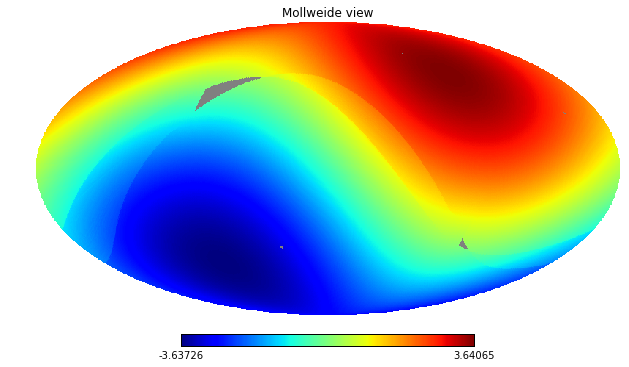

In [13]:
hp.mollview(rings.clean_map(m_prev))

In [14]:
g_prev = fiducial_gain

In [15]:
g_prev

0     3
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
...
5986    3
5987    3
5988    3
5989    3
5990    3
5991    3
5992    3
5993    3
5994    3
5995    3
5996    3
5997    3
5998    3
5999    3
6000    3
Length: 6001, dtype: float64

Create raw data from simulated data, i.e. **decalibrate**

In [16]:
R.data.c *= fiducial_gain.reindex(R.data.c.index)

In [17]:
RHS = rcal.create_RHS(R, g_prev, m_prev, M=M, 
                      dipole_map=dipole_map,
                      dipole_map_cond=dipole_map_cond)
matvec = rcal.create_matvec(R, g_prev, m_prev, M=M, dipole_map=dipole_map,
                            dipole_map_cond=dipole_map_cond)

In [18]:
m_prev.sum()

I   -144.017975
dtype: float64

In [19]:
LHS = matvec(fiducial_solution)

In [20]:
n_pids = len(R.pids)

In [21]:
assert np.allclose(LHS[:n_pids], RHS[:n_pids])

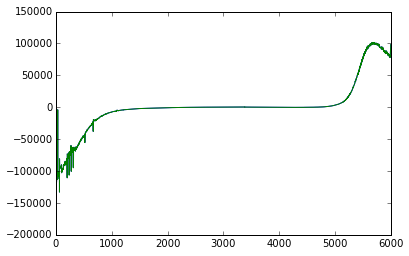

In [22]:
plt.plot(RHS[n_pids:])
plt.plot(LHS[n_pids:])

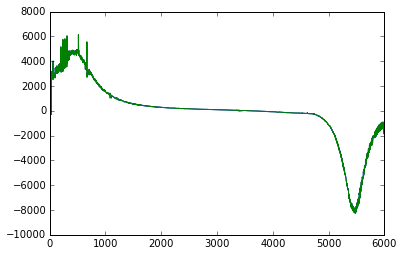

In [23]:
plt.plot(RHS[:n_pids])
plt.plot(LHS[:n_pids])

In [24]:
assert np.allclose(LHS[n_pids:], RHS[n_pids:])